<a href="https://colab.research.google.com/github/ShuttleSantalex/painting16-20-recognition/blob/main/paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! [ -e /content ] && pip install -Uqq fastbook
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search
import fastbook
fastbook.setup_book()

Download image method

In [8]:
from fastcore.all import *
from duckduckgo_search import ddg_images
import time

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a 16th century paintings and seeing what kind of result we get. We'll start by getting URLs from a search:


In [11]:
urls = search_images('painting 16th century', max_images=1)
urls[0]

'https://images.fineartamerica.com/images-medium-large-5/the-annunciation-early-16th-century-bernart-van-orley.jpg'

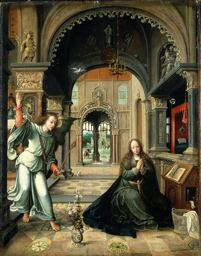

In [12]:
from fastdownload import download_url
dest = 'painting-16th.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Let's do the same with paintings fo the 20th century

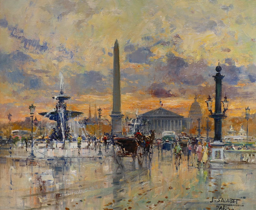

In [13]:
download_url(search_images('painting 20th century', max_images=1)[0], 'car.jpg', show_progress=False)
Image.open('car.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "photo of a car" and "photo of a damaged car" photos, and save each group of photos to a different folder:



In [14]:
searches = 'painting 16th century','painting 20th century'
path = Path('painting_epoc')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [15]:
print(path)

painting_epoc


Filter broken photos

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:



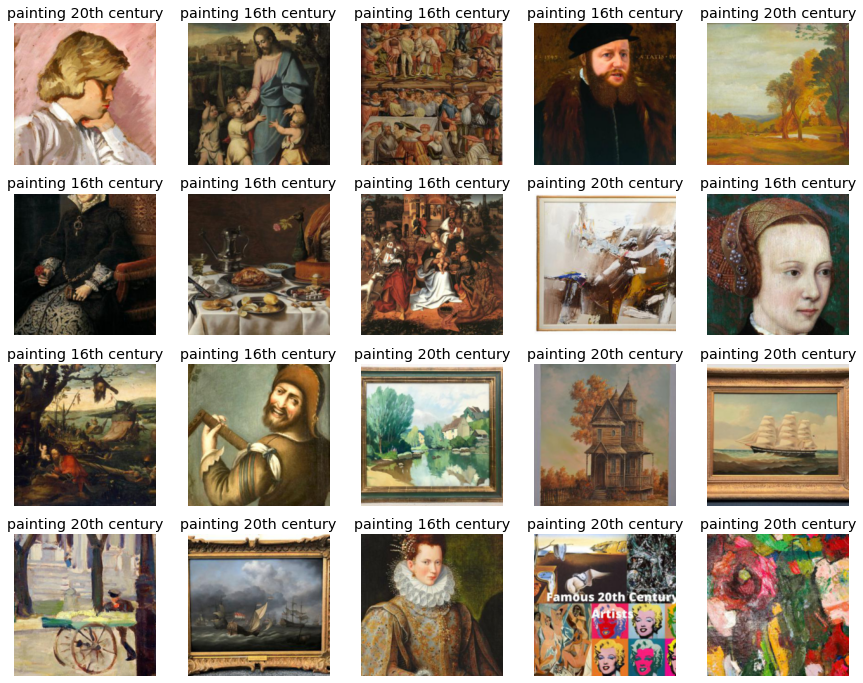

In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224)]
).dataloaders(path)

dls.show_batch(max_n=20)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(30)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.077547,1.063921,0.277778,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.482286,0.430198,0.138889,00:02
1,0.452645,0.308452,0.111111,00:02
2,0.384954,0.280100,0.097222,00:02
3,0.349080,0.256319,0.111111,00:02
4,0.298049,0.248828,0.083333,00:02
5,0.254319,0.245211,0.069444,00:02
6,0.215188,0.253907,0.055556,00:02
7,0.183863,0.265607,0.069444,00:02
8,0.159773,0.286361,0.055556,00:02
9,0.140680,0.272530,0.069444,00:02


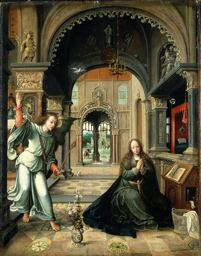

In [21]:
download_url(search_images('painting 16th century', max_images=1)[0], 'painting-16th.jpg', show_progress=False)
Image.open('painting-16th.jpg').to_thumb(256,256)

In [22]:
is_normal,_,probs = learn.predict(PILImage.create('painting-16th.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's a 16th century paiting: {probs[0]:.4f}")

This is a: painting 16th century.
Probability it's a 16th century paiting: 0.9997


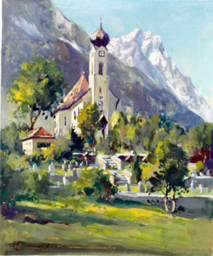

In [23]:
download_url(search_images('photo of 20th century painting', max_images=1)[0], 'painting-20th.jpg', show_progress=False)
Image.open('painting-20th.jpg').to_thumb(256,256)

In [24]:
is_normal,_,probs = learn.predict(PILImage.create('painting-20th.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's a 20th century painting: {probs[0]:.4f}")

This is a: painting 20th century.
Probability it's a 20th century painting: 0.0000
